# Kaggle 자전거 수요 예측을 위한 회귀 모형 학습

* 데이터 출처  
https://www.kaggle.com/competitions/bike-sharing-demand/data
#
* 분석 출처  
https://www.youtube.com/watch?v=Q_MbN-vu_2w&list=PLaTc2c6yEwmotOgH9PIBpLf3CZEXdD41q&index=3  

### EDA

In [11]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

plt.style.use('ggplot') # plt.style.available 가능한 스타일 목록 확인

mpl.rcParams['font.family'] = 'D2Coding' # 한글 폰트 설정

In [54]:
train = pd.read_csv('example_data/bikesharing_train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
train.shape

(10886, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<AxesSubplot:>

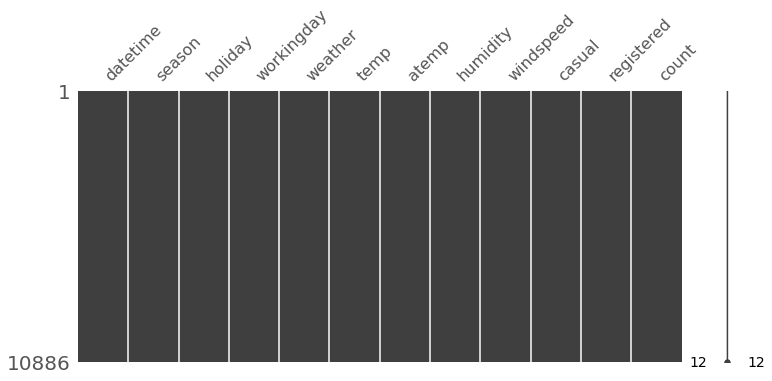

In [7]:
import missingno as msno # 결측치 시각화

msno.matrix(train, figsize=(12,5))

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train.shape

(10886, 18)

In [9]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

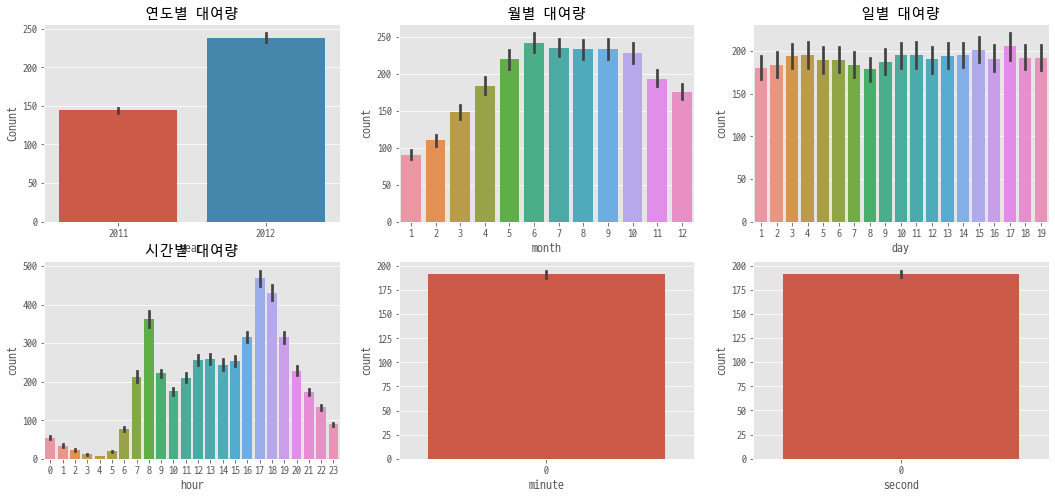

In [12]:
# 시각화 (barplot) 
# barplot 의 estimator default 값은 평균값. 중앙값, 빈도수 등 다양한 적용 가능

figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(18,8))

sns.barplot(x='year', y='count', data=train, ax=ax1)
sns.barplot(x='month', y='count', data=train, ax=ax2)
sns.barplot(x='day', y='count', data=train, ax=ax3)
sns.barplot(x='hour', y='count', data=train, ax=ax4)
sns.barplot(x='minute', y='count', data=train, ax=ax5)
sns.barplot(x='second', y='count', data=train, ax=ax6)

ax1.set(ylabel="Conunt", title="연도별 대여량")
ax2.set(xlabel="month", title="월별 대여량")
ax3.set(xlabel="day", title="일별 대여량")
ax4.set(xlabel="hour", title="시간별 대여량")

* 연도별 대여량 2011 < 2012
* 월별 대여량은 6월 최고치. 1월 최저치. 7~10월도 많음
* 일별 대여량은 1~19일까지만 있음 -> 피쳐로 사용 불가
* 시간별 대여량은 출퇴근 시간에 대여량이 많음
* 분, 초 모두 0 이기 때문에 의미 없음

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

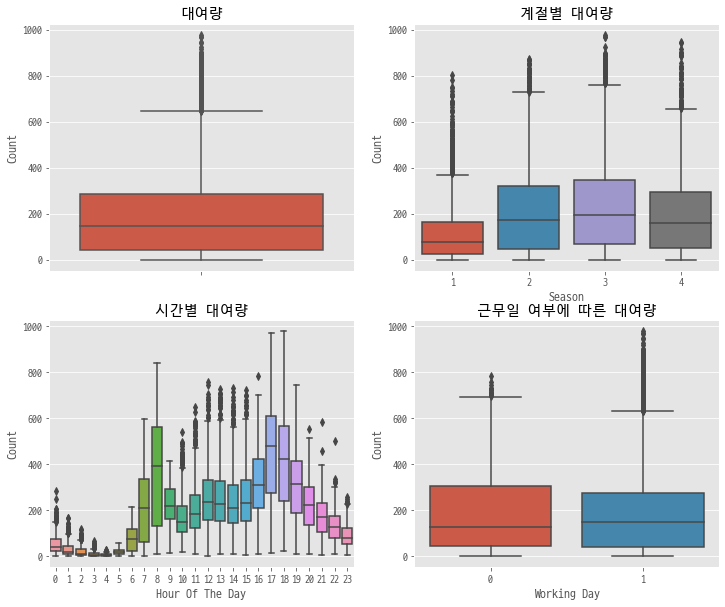

In [13]:
# 시각화 (boxplot)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
sns.boxplot(data=train, y="count", orient="v", ax=axes[0][0])
sns.boxplot(data=train, y="count", x="season", orient="v", ax=axes[0][1])
sns.boxplot(data=train, y="count", x="hour", orient="v", ax=axes[1][0])
sns.boxplot(data=train, y="count", x="workingday", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel="Count", title="대여량")
axes[0][1].set(xlabel="Season", ylabel='Count', title="계절별 대여량")
axes[1][0].set(xlabel="Hour Of The Day", ylabel='Count', title="시간별 대여량")
axes[1][1].set(xlabel="Working Day", ylabel='Count', title="근무일 여부에 따른 대여량")

* 전체 대여량을 보면 특정 구간에 몰려있는 것을 알 수 있음
* 계절별 대여량은, 3 > 2 > 4 > 1 순인 것을 알 수 있음
    * 계절 설명
        * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* 시간 별 대여량은 barplot 과 유사함을 알 수 있음
* 근무일 여부에 따른 대여량은 근무일 여부에 따라 크게 다르지 않지만, 근무일이 아닐 때 대여량이 많음 

In [14]:
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [15]:
train['dayofweek'].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='hour', ylabel='count'>

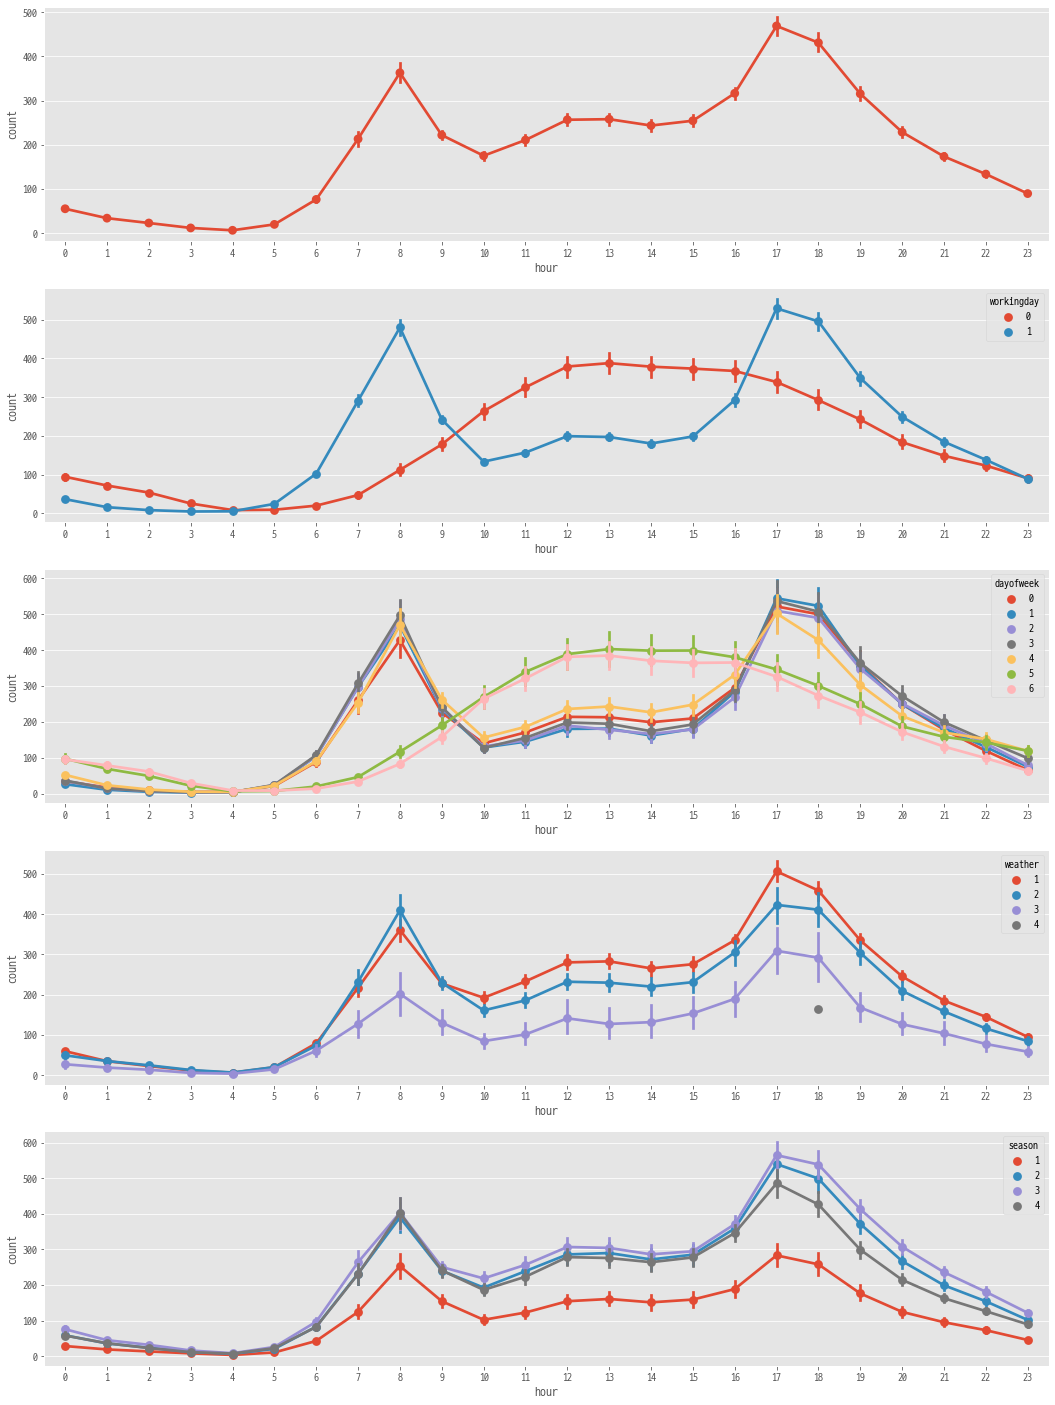

In [17]:
# 시각화 (pointplot)

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, figsize=(18,25))

sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [18]:
# 상관관계

corrMat = train[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr()
print(corrMat)

mask = np.array(corrMat)
mask[np.tril_indices_from(mask)] = False
# 'np.tril_indices_from' returns the indices for the lower-triangle of arr.

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


<AxesSubplot:>

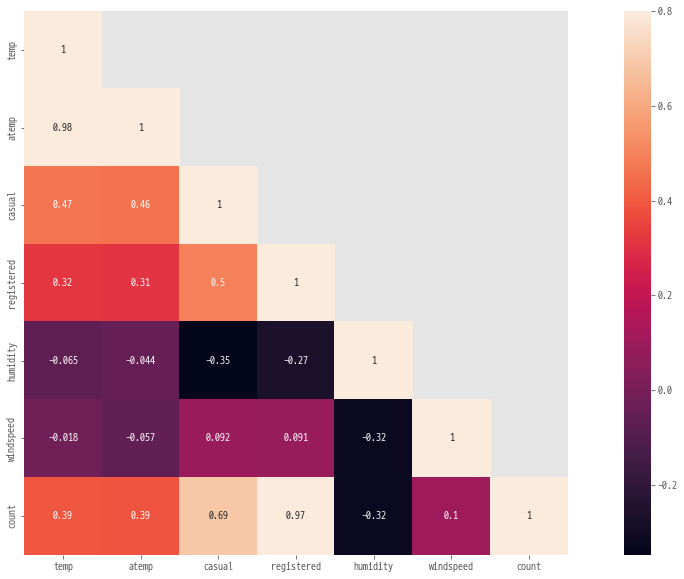

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMat, mask=mask, vmax=.8, square=True, annot=True)

* 온도, 습도, 풍속은 거의 연관관계가 없음
* count 와 가장 연관관계가 높은 것은 registered 이지만, test 에는 해당 값 없음
* atemp 와 temp 는 0.98 로 상관관계가 높지만, 온도 체감온도로 피처에 사용하기에 적합하지 않을 수 있음

<AxesSubplot:xlabel='humidity', ylabel='count'>

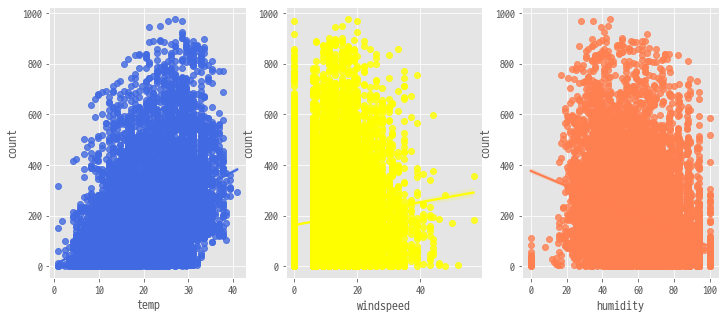

In [22]:
# 시각화 (산점도)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12,5))

sns.regplot(x="temp", y="count", data=train, color='royalblue', ax=ax1)
sns.regplot(x="windspeed", y="count", data=train, color='yellow', ax=ax2)
sns.regplot(x="humidity", y="count", data=train, color='coral', ax=ax3)

In [23]:
# 풍속의 경우, 0에 많이 몰려있는 것 확인. -> 관측되지 않은 값을 0으로 기록한 것이 아닐까 추측

In [24]:
def concatenate_year_month(datetime):
    return "{}-{}".format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)
train[["datetime", "year_month"]].head()

,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


<AxesSubplot:xlabel='year_month', ylabel='count'>

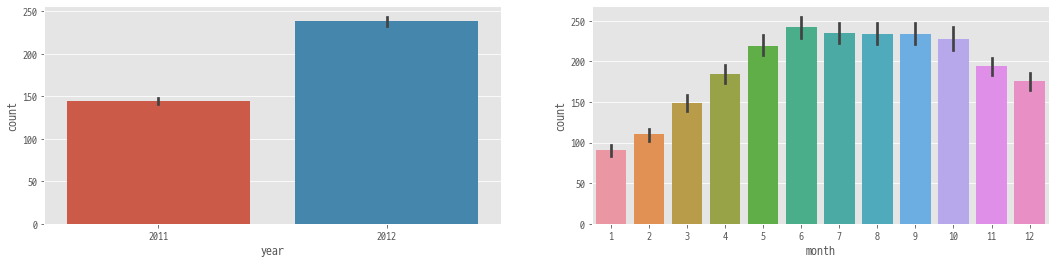

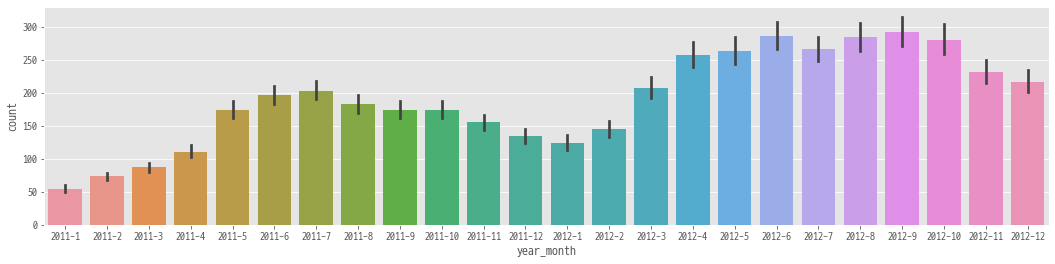

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,4))

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(18,4))
sns.barplot(data=train, x="year_month", y="count", ax=ax3)

* 2012 > 2021
* 여름 > 겨울
* 2011년과 2012년의 월별 데이터를 이어보면 전체적으로 증가하는 추세

In [26]:
# outliers 제거

trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3 * train['count'].std())]

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229765, 4.562423868087808, 0.9581176780909608))

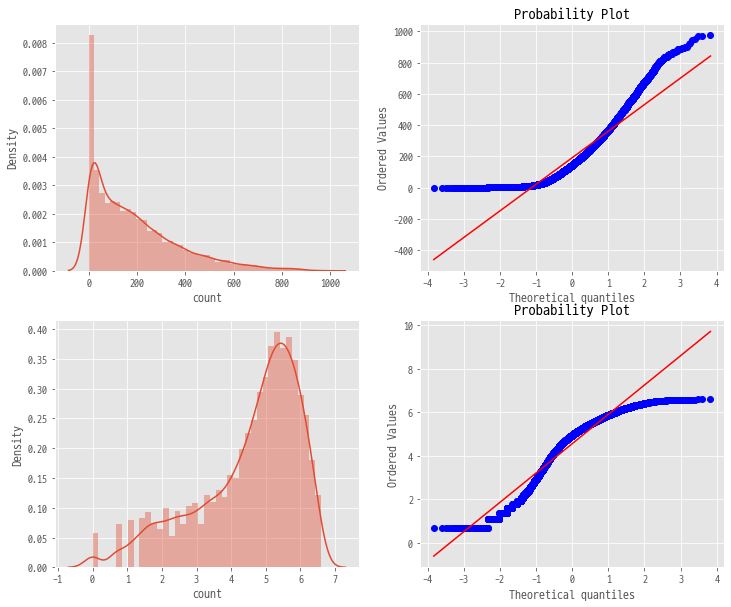

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

* stats.probplot :  
산점도의 점들이 빨간색 선 주위에 모일수록 정규분포를 띄고 있는 것이라고 보면 됨

* 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직
    * count변수가 오른쪽에 치우쳐져 있음.  
    * 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않음 (이전 그래프보다는 좀 더 자세히 표현)

### Evaluation : RMSLE & K-fold

* RMSLE (Root Mean Squared Logarithmic Error)
* 과대평가된 항목보다는 과소평가된 항목에 패널티
* 0에 가까운 값이 나올수록 정밀도가 높은 값
* $ RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log(p_i+1)-log(a_i
+1))^2} $

In [33]:
from sklearn.metrics import make_scorer

def rmsle (y_pred, y):
    y_pred = np.array(y_pred)
    y = np.array(y)

    log_y_pred = np.log1p(y_pred)
    log_y = np.log1p(y)

    difference = np.square(log_y_pred - log_y)
    mean_difference = difference.mean()
    
    return np.sqrt(mean_difference)

In [97]:
# k-fold cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

number = 10
k_fold = KFold(n_splits=number, shuffle=True, random_state=0)

### Feature Engineering

In [77]:
train = pd.read_csv("example_data/bikesharing_train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [78]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [79]:
test = pd.read_csv("example_data/bikesharing_test.csv", parse_dates=["datetime"])
test.shape

(6493, 9)

In [80]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

In [81]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second,dayofweek
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0,3


<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

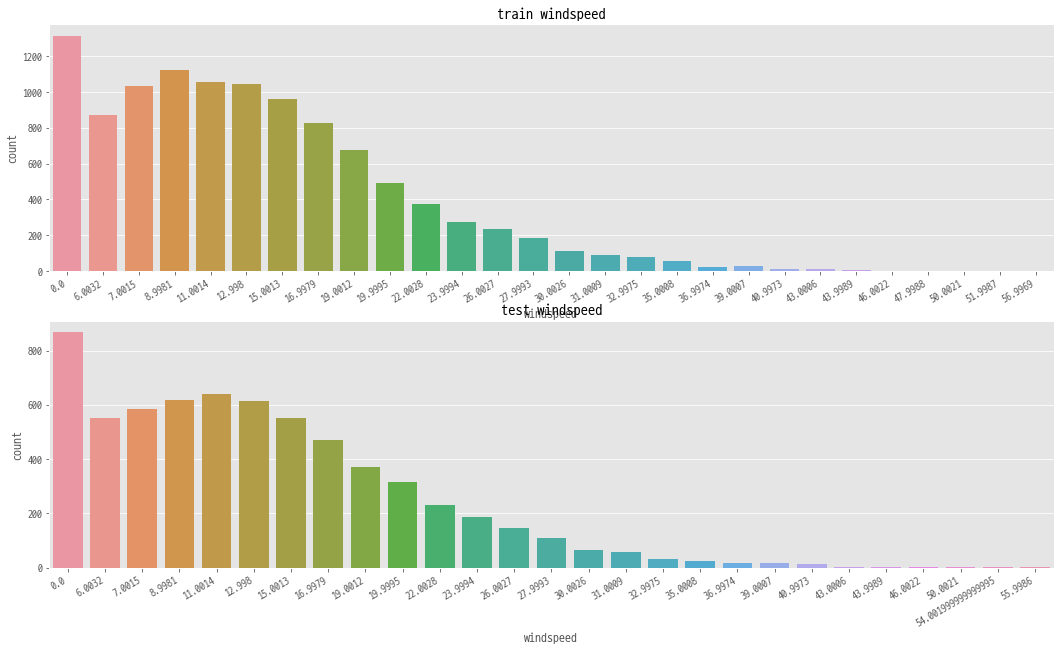

In [82]:
# windspeed 시각화 -> 0값이 가장 많으므로 잘못된 데이터 고쳐줘야 함

fig, axes = plt.subplots(nrows=2, figsize=(18,10))

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='count', title='train windspeed')
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='count', title='test windspeed')
sns.countplot(data=test, x="windspeed", ax=axes[1])



* 측정이 되지 않은 데이터들을 0으로 기록하지 않았나하는 추측  
-> 특정값을 넣어주려고 함  
#
* 평균값을 일괄적으로 넣어줄수도 있지만, 정확도를 높이는 데 도움이 되지 않을 수도  
-> ML 기반 예측값으로 풍속 값을 넣어주고자 함

In [83]:
## 평균값을 일괄적으로 대체할 때
#train.loc[train['windspeed'] == 0, 'windspeed'] = train['windspeed'].mean()
#test.loc[test['windspeed'] == 0, 'windspeed'] = train['windspeed'].mean()

In [84]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]

    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype("str") # 회귀가 아닌 분류로 접근

    rfModel_wind = RandomForestClassifier()
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    predWind0 = dataWind0
    predWindNot0 = dataWindNot0
    predWind0['windspeed'] = wind0Values
    data = predWindNot0.append(predWind0)
    data['windspeed'] = data['windspeed'].astype("float")
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data



/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

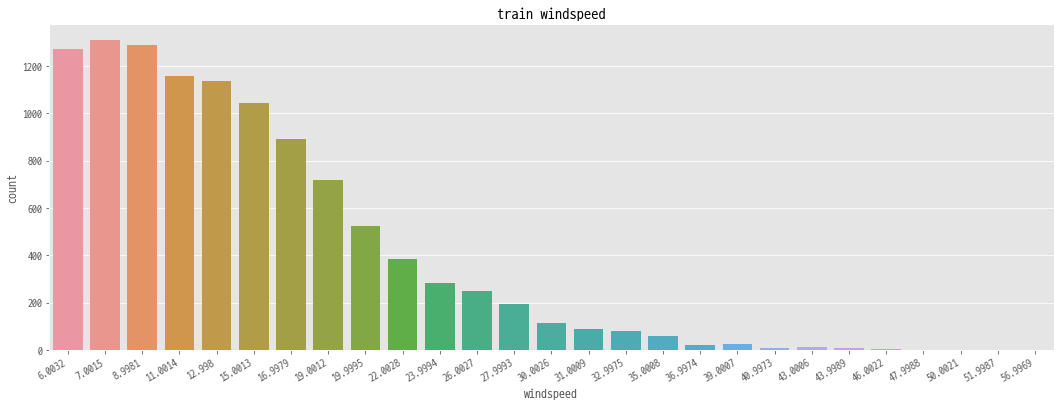

In [85]:
train = predict_windspeed(train)
# test = predict_windspeed(test)

fig, ax = plt.subplots(figsize=(18, 6))

plt.sca(ax)
plt.xticks(rotation=30, ha='right') # 글씨 겹쳐 보이는 것 방지
ax.set(ylabel='count', title='train windspeed')
sns.countplot(data=train, x="windspeed", ax=ax)

### Feature Selection

* 신호 - 잡음 구분
* 피쳐가 많다고 좋은 성능을 내는 것은 아님  
-> 피쳐를 하나씩 추가하고 변경해가면서, 성능이 좋지 않은 피쳐 제거

In [86]:
categorical_features = ['season', 'holiday', 'workingday', 'weather', 
'dayofweek', 'month', 'year', 'hour']

for var in categorical_features:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [87]:
features = ['season', 'holiday', 'workingday', 'weather', 
'dayofweek', 'month', 'year', 'hour'] + ['temp', 'atemp', 'humidity', 'windspeed']

features

['season',
 'holiday',
 'workingday',
 'weather',
 'dayofweek',
 'month',
 'year',
 'hour',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [88]:
X_train = train[features]
print("X_train.shape:", X_train.shape)

X_test = test[features]
print("X_test.shape:", X_test.shape)

X_train.head()

X_train.shape: (10886, 12)
X_test.shape: (6493, 12)


,season,holiday,workingday,weather,dayofweek,month,year,hour,temp,atemp,humidity,windspeed
0,1,0,0,2,5,1,2011,5,9.84,12.880,75,6.0032
1,1,0,0,1,5,1,2011,10,15.58,19.695,76,16.9979
2,1,0,0,1,5,1,2011,11,14.76,16.665,81,19.0012
3,1,0,0,1,5,1,2011,12,17.22,21.210,77,19.0012
4,1,0,0,2,5,1,2011,13,18.86,22.725,72,19.9995


In [89]:
label = "count"

y_train = train[label]
print("y_train.shape:", y_train.shape)
y_train.head()

y_train.shape: (10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

### Random Forest

In [91]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []
model = RandomForestRegressor(n_estimators=100, 
n_jobs=-1, 
random_state=0)

model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [92]:
from sklearn.metrics import make_scorer

rmsle_scorer = make_scorer(rmsle)

In [100]:
%time 
score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
print("scores : ", score)
score = score.mean()
print("score:", score)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 3.1 µs
scores :  [0.3104684  0.33503376 0.32592489 0.31591723 0.31200741 0.33304233
 0.32854862 0.31212106 0.3356321  0.32918901]
score: 0.32378848036892355


### Train

In [102]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("shape of predictions: ", predictions.shape)
print("10 of predictions: ", predictions[:10])

shape of predictions:  (6493,)
10 of predictions:  [ 11.82   5.37   4.12   3.5    3.08   5.5   35.15  89.53 200.68 122.1 ]


/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'test')]

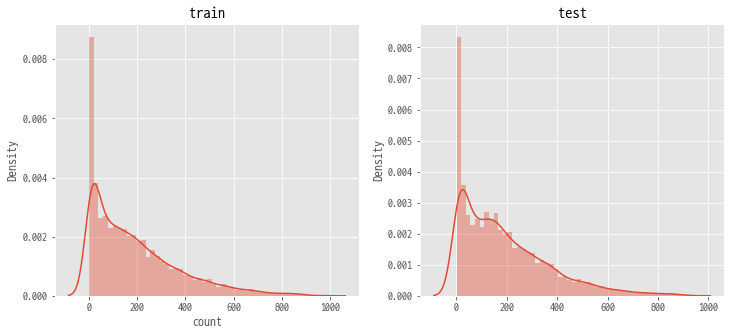

In [103]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title="train")
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title="test")